In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Load files

In [2]:
wine_reviews = pd.read_csv("no-punctuation/wine-reviews-no-punc.csv")
wine_reviews.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,logit_score
0,0,0,Italy,Aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0
1,1,1,Portugal,This is ripe and fruity a wine that is smooth ...,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0
2,2,2,US,Tart and snappy the flavors of lime flesh and ...,NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0
3,3,3,US,Pineapple rind lemon pith and orange blossom s...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0
4,4,4,US,Much like the regular bottling from 2012 this ...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0


### Train-test split

In [3]:
#use a specific seed for reproducibility
train, test = train_test_split(wine_reviews, random_state = 1337)

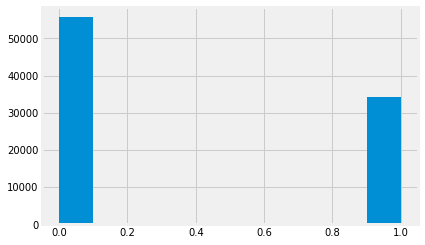

In [4]:
train['logit_score'].hist()

In [5]:
len(train[train['logit_score'] == 1])/len(train[train['logit_score'] == 0])

0.6148406088454911

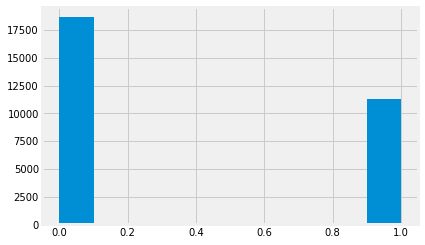

In [6]:
test['logit_score'].hist()

In [7]:
len(test[test['logit_score'] == 1])/len(test[test['logit_score'] == 0])

0.6067831118731247

Hence, the split of train good and bad is roughly the same percentage as the split of test good and bad. 

In [8]:
text_train = np.array(train['description'])
y_train = np.array(train['logit_score'])

In [9]:
text_test = np.array(test['description'])
y_test = np.array(test['logit_score'])

### Save training and test files if needed

In [11]:
#np.savetxt("text_train.csv", text_train, fmt="%s", encoding='utf-8')
#np.savetxt("y_train.csv", y_train)
#np.savetxt("text_test.csv", text_test, fmt="%s", encoding='utf-8')
#np.savetxt("y_test.csv", y_test)

### Vectorize and tokenize words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1, 2))
X_train = vect.fit(text_train).transform(text_train)
X_test = vect.transform(text_test)

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("X_train:\n{}".format(repr(X_train)))
print("X_test: \n{}".format(repr(X_test)))

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Vocabulary size: 570915
X_train:
<89966x570915 sparse matrix of type '<class 'numpy.int64'>'
	with 6463094 stored elements in Compressed Sparse Row format>
X_test: 
<29989x570915 sparse matrix of type '<class 'numpy.int64'>'
	with 2036186 stored elements in Compressed Sparse Row format>
Number of features: 570915


# Logistic Regression

### Train the model

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.85
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [22]:
#check feature coefficients
grid.best_estimator_.coef_

array([[ 0.01270633, -0.00170771,  0.04117979, ...,  0.00073074,
        -0.00272517, -0.00272517]])

### Check coefficient values of specific words

In [23]:
for i in range(len(feature_names)):
    if(feature_names[i]  == 'acid'):
        idx = i
        print(idx)
        break

10231


In [24]:
feature_names[idx]

'acid'

In [25]:
grid.best_estimator_.coef_[0][idx]

-0.33218308264786833

### Plot top 25 words (both + and -)

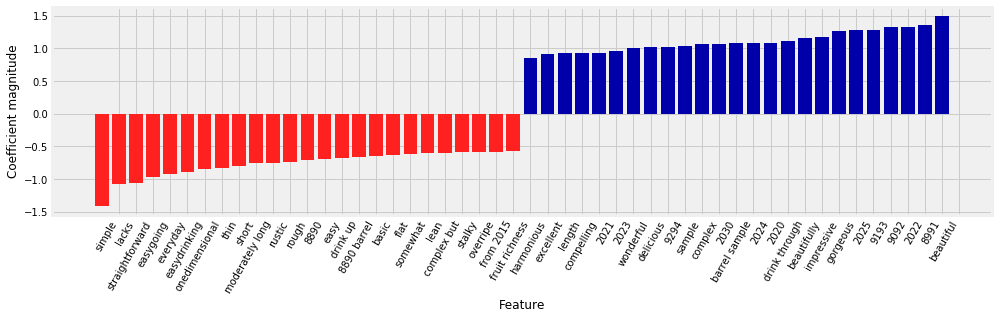

In [27]:
import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=25)
plt.savefig("word_association_plot.png", dpi = 250, bbox_inches = 'tight')

### Check performance statistics

In [28]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.85


In [29]:
y_pred = grid.predict(X_test)

In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8479442462236153


In [36]:
#C00 = true neg, C10 = false neg, C11 = true pos, C01 = false pos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[16760,  1904],
       [ 2656,  8669]], dtype=int64)

### Check random reviews

In [37]:
rev = ["The nose is currently a bit closed, eventually offering shades of red and blue berries. The palate has more to tell, giving way to flavors of juicy cranberry and tart blueberry, with a gentle hug of tannins providing support."]

In [38]:
print("rev prediction: {}". format(lr.predict(vect.transform(rev))))

rev prediction: [0]


### Summary of no punctuation vs no punctuation + digit

No punctuation:
-   accuracy: 0.848
-   score: 0.85
-   conf_matrix: [[16760, 1904], [2656, 8669]]

# SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(SVC(kernel = 'linear'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

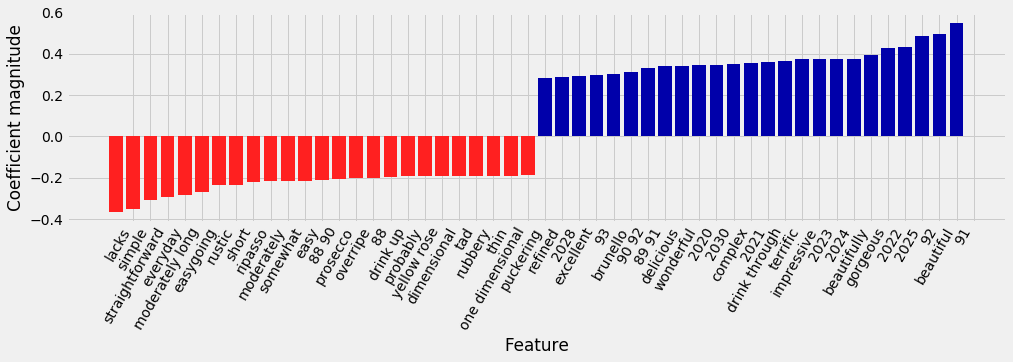

In [51]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=25)
plt.show()

In [52]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.85


In [60]:
rev = ["Roasted, earthy berry aromas come with notes of latex and Band-Aid. This Merlot feels saucy and soupy, without much structure. Herbal plum and raspberry flavors finish with lighter but similar flavors."]

In [61]:
print("rev prediction: {}". format(lr.predict(vect.transform(rev))))

rev prediction: [0]


# Neural Networks